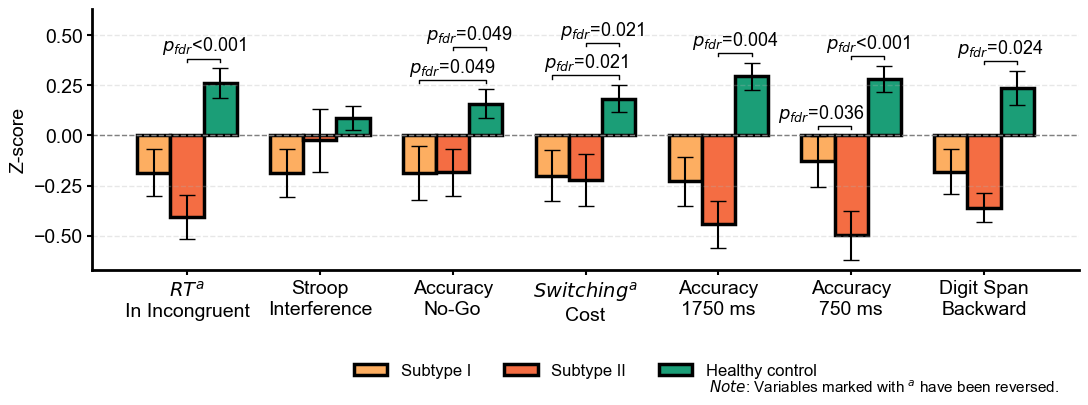

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats

# 设置全局matplotlib参数（Nature风格）
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "legend.fontsize": 12,
    "grid.linewidth": 1.0,
    "lines.linewidth": 1.5,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# 定义配色方案及背景色
BG_WHITE = '#ffffff'
COLOR_SCALE = ["#fdae61", "#f46d43", "#1b9e77"]

# 定义特定注释的水平偏移参数（仅用于文本）
# 以 (变量名, 组索引1, 组索引2) 作为键，值为水平偏移量
ANNOTATION_SHIFT = {
    ('Accuracy_in_750_ms', 0, 1): -0.1
}

def get_star(p):
    """返回显著性星号"""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

def plot_overall_EF_bar_chart(data, ef_vars, output_path):
    """
    1. 对所有EF变量进行z标准化；
       - 对于反应时相关指标（反应时、转换成本）先反向，使高分代表更好表现，
         然后进行z标准化；其他指标直接进行z标准化。
    2. 计算各组各变量的均值和标准误；
    3. 用分组bar图展示各组在各EF变量上的整体pattern；
    4. 对长变量名称采用换行符\n或者缩写展示，并在变量名称上添加上标 (例如 $^{a}$)；
    5. 在图中添加说明文字，指出带有上标的指标已取反转换；
    6. 对显著的两组比较添加横线及p值和星号标注，并对同一变量的多重标注自动垂直错开，
       但对于Accuracy_in_750_ms中p<0.001的标注，不作垂直叠加，保持同一高度，且在p值文本与横线间增加额外间隔。
    """
    data = data.copy()
    data.loc[:, 'Group'] = data['Group'].replace({0: 'Subtype I', 1: 'Subtype II', 2: 'Healthy control'})
    data = data[data['Group'] != 3]
    
    rt_vars = ['Reaction_times_in_incongruent_stimuli', 'Switching_cost']
    for var in ef_vars:
        if var in rt_vars:
            data[var + '_z'] = - (data[var] - data[var].mean()) / data[var].std()
        else:
            data[var + '_z'] = (data[var] - data[var].mean()) / data[var].std()
    
    groups = ['Subtype I', 'Subtype II', 'Healthy control']
    mean_dict = {grp: [] for grp in groups}
    se_dict = {grp: [] for grp in groups}
    for var in ef_vars:
        for grp in groups:
            vals = data[data['Group'] == grp][var + '_z']
            mean_dict[grp].append(vals.mean())
            se_dict[grp].append(vals.std() / np.sqrt(len(vals)))
    
    x = np.arange(len(ef_vars))
    width = 0.25

    fig, ax = plt.subplots(figsize=(11, 4.8))
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    bars_subI  = ax.bar(x - width, mean_dict['Subtype I'], width,
                        yerr=se_dict['Subtype I'], capsize=6,
                        color=COLOR_SCALE[0], label='Subtype I',
                        edgecolor='black', linewidth=2.5, ecolor='black')
    bars_subII = ax.bar(x,          mean_dict['Subtype II'], width,
                        yerr=se_dict['Subtype II'], capsize=6,
                        color=COLOR_SCALE[1], label='Subtype II',
                        edgecolor='black', linewidth=2.5, ecolor='black')
    bars_hc    = ax.bar(x + width, mean_dict['Healthy control'], width,
                        yerr=se_dict['Healthy control'], capsize=6,
                        color=COLOR_SCALE[2], label='Healthy control',
                        edgecolor='black', linewidth=2.5, ecolor='black')

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + (ymax - ymin) * 0.20)

    sig_annotations = {
        'Reaction_times_in_incongruent_stimuli': [(1, 2, 0.000)],
        'Accuracy_in_No_Go_trials':              [(0, 2, 0.049), (1, 2, 0.049)],
        'Switching_cost':                        [(0, 2, 0.021), (1, 2, 0.021)],
        'Accuracy_in_1750_ms':                   [(1, 2, 0.004)],
        'Accuracy_in_750_ms':                    [(0, 1, 0.036), (1, 2, 0.000)],
        'Span_in_digit_span_backward_task':      [(1, 2, 0.024)]
    }
    group_bars = [bars_subI, bars_subII, bars_hc]
    for i, var in enumerate(ef_vars):
        if var in sig_annotations:
            for idx, (g1, g2, p_val) in enumerate(sig_annotations[var]):
                rect1 = group_bars[g1][i]
                rect2 = group_bars[g2][i]
                # 横线位置按原位计算
                x1 = rect1.get_x() + rect1.get_width() / 2
                x2 = rect2.get_x() + rect2.get_width() / 2
                y1 = mean_dict[groups[g1]][i] + se_dict[groups[g1]][i]
                y2 = mean_dict[groups[g2]][i] + se_dict[groups[g2]][i]
                base_y = max(y1, y2) + (ymax - ymin) * 0.03
                offset = (ymax - ymin) * 0.15

                # 对于Accuracy_in_750_ms中p<0.001的标注，不作垂直叠加
                if var == 'Accuracy_in_750_ms' and p_val < 0.001:
                    y = base_y
                else:
                    y = base_y + idx * offset

                h = (ymax - ymin) * 0.015
                # 绘制连线
                ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y],
                        lw=1, c='black')
                # 计算文本偏移后的位置
                shift = ANNOTATION_SHIFT.get((var, g1, g2), 0)
                text_x = (x1 + x2) / 2 + shift
                extra_gap = (ymax - ymin) * 0.008
                # 文本内容
                if p_val < 0.001:
                    p_text = "$p_{fdr}$<0.001"
                else:
                    p_text = f"$p_{{fdr}}$={p_val:.3f}"
                # 添加文本
                ax.text(text_x, y + h + extra_gap,
                        p_text,
                        ha='center', va='bottom', fontsize=13)

    ax.set_xticks(x)
    var_label_mapping = {
        'Reaction_times_in_incongruent_stimuli': '$RT^{a}$\nIn Incongruent',
        'Stroop_interference_effect': 'Stroop\nInterference',
        'Accuracy_in_No_Go_trials': 'Accuracy\nNo-Go',
        'Switching_cost': '$Switching^{a}$\nCost',
        'Accuracy_in_1750_ms': 'Accuracy\n1750 ms',
        'Accuracy_in_750_ms': 'Accuracy\n750 ms',
        'Span_in_digit_span_backward_task': 'Digit Span\nBackward'
    }
    formatted = [
        var_label_mapping.get(var, var.replace("_", " ").title())
        for var in ef_vars
    ]
    ax.set_xticklabels(formatted, rotation=0)
    ax.set_ylabel("Z-score")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.legend(frameon=False, loc='upper left',
              bbox_to_anchor=(0.25, -0.3), ncol=3)

    ax.text(0.98, -0.48,
            "$Note$: Variables marked with $^{a}$ have been reversed.",
            transform=ax.transAxes, fontsize=11, color='black',
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='none', alpha=0.8, edgecolor='none'))

    plt.tight_layout()
    plt.savefig(output_path, dpi=1600, bbox_inches='tight')
    plt.show()

# ----------------- 主程序 -----------------
all_dependent_vars = [
    'Reaction_times_in_incongruent_stimuli',
    'Stroop_interference_effect',
    'Accuracy_in_No_Go_trials',
    'Switching_cost',
    'Accuracy_in_1750_ms',
    'Accuracy_in_750_ms',
    'Span_in_digit_span_backward_task'
]

data_all = pd.read_excel('执行功能.xlsx', sheet_name='Sheet1')
data_all = data_all[data_all['Group'] != 3]

overall_output_path = "./output_folder/overall_EF_pattern_bar_chart.jpg"
os.makedirs("./output_folder", exist_ok=True)

plot_overall_EF_bar_chart(data_all, all_dependent_vars, overall_output_path)


单因素方差分析结果:
原始p值及FDR BH矫正后的p值:
                             Variable     F     p  Eta_squared  p_corr
Reaction_times_in_incongruent_stimuli 9.417 0.000        0.057   0.000
           Stroop_interference_effect 1.212 0.299        0.008   0.299

变量: Reaction_times_in_incongruent_stimuli
亚组I与健康对照组的Cohen's d: 0.350
亚组II与健康对照组的Cohen's d: 0.569
置换检验p值: 0.200
各组均值和标准差:
          Group    mean     std
Healthy control -31.935 143.051
      Subtypt I  20.004 153.639
     Subtypt II  52.010 151.904
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.041   -0.350
Healthy control Subtypt II    0.000   -0.569
      Subtypt I Subtypt II    0.395   -0.209

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I   0.061   -0.350
Healthy control Subtypt II   0.000   -0.569
      Subtypt I Subtypt II   0.395   -0.209


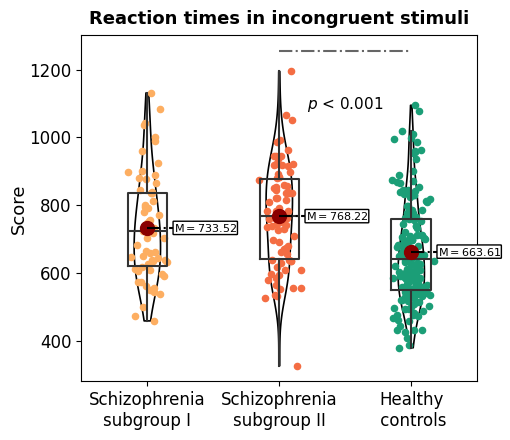



变量: Stroop_interference_effect
亚组I与健康对照组的Cohen's d: -0.254
亚组II与健康对照组的Cohen's d: -0.064
置换检验p值: 0.254
各组均值和标准差:
          Group   mean    std
Healthy control  3.781 44.826
      Subtypt I -9.137 56.362
     Subtypt II -0.344 79.092
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.267    0.254
Healthy control Subtypt II    0.860    0.064
      Subtypt I Subtypt II    0.629   -0.128

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I    0.80    0.254
Healthy control Subtypt II    0.86    0.064
      Subtypt I Subtypt II    0.86   -0.128


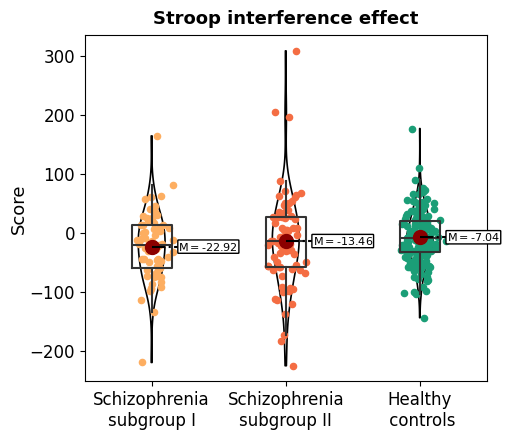



效应量和置换检验p值已保存到 Excel 文件: ./output_folder/output1/effect_sizes_and_permutation_p_values.xlsx

所有事后检验完成。

单因素方差分析结果:
原始p值及FDR BH矫正后的p值:
                Variable     F     p  Eta_squared  p_corr
Accuracy_in_No_Go_trials 4.983 0.007        0.031   0.007
          Switching_cost 6.508 0.002        0.040   0.003

变量: Accuracy_in_No_Go_trials
亚组I与健康对照组的Cohen's d: -0.354
亚组II与健康对照组的Cohen's d: -0.358
置换检验p值: 0.981
各组均值和标准差:
          Group   mean   std
Healthy control  0.019 0.109
      Subtypt I -0.023 0.126
     Subtypt II -0.021 0.117
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.033    0.354
Healthy control Subtypt II    0.028    0.358
      Subtypt I Subtypt II    0.997   -0.011

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I   0.049    0.354
Healthy control Subtypt II   0.049    0.358
      Subtypt I Subtypt II   0.997   -0.011


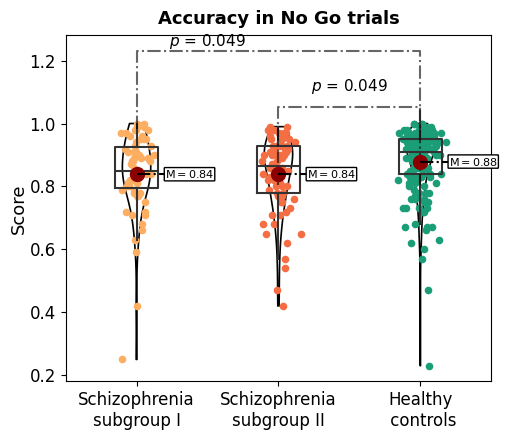



变量: Switching_cost
亚组I与健康对照组的Cohen's d: 0.415
亚组II与健康对照组的Cohen's d: 0.396
置换检验p值: 0.909
各组均值和标准差:
          Group    mean     std
Healthy control -50.716 236.283
      Subtypt I  59.012 289.836
     Subtypt II  59.194 313.503
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.014   -0.415
Healthy control Subtypt II    0.009   -0.396
      Subtypt I Subtypt II    1.000   -0.001

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I   0.021   -0.415
Healthy control Subtypt II   0.021   -0.396
      Subtypt I Subtypt II   1.000   -0.001


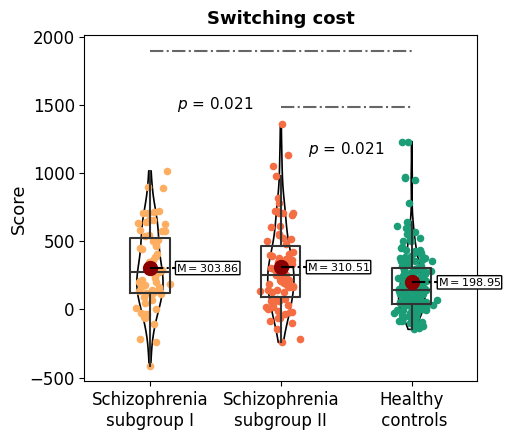



效应量和置换检验p值已保存到 Excel 文件: ./output_folder/output2/effect_sizes_and_permutation_p_values.xlsx

所有事后检验完成。

单因素方差分析结果:
原始p值及FDR BH矫正后的p值:
                        Variable     F     p  Eta_squared  p_corr
             Accuracy_in_1750_ms 7.327 0.001        0.045   0.001
              Accuracy_in_750_ms 8.650 0.000        0.053   0.001
Span_in_digit_span_backward_task 5.480 0.005        0.034   0.005

变量: Accuracy_in_1750_ms
亚组I与健康对照组的Cohen's d: -0.348
亚组II与健康对照组的Cohen's d: -0.481
置换检验p值: 0.427
各组均值和标准差:
          Group   mean   std
Healthy control  0.044 0.210
      Subtypt I -0.035 0.244
     Subtypt II -0.067 0.250
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.044    0.348
Healthy control Subtypt II    0.001    0.481
      Subtypt I Subtypt II    0.679    0.129

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I   0.066    0.348
Healthy control Subtypt II   0.004    0.481
      Subtypt I Subtypt II   0.679   

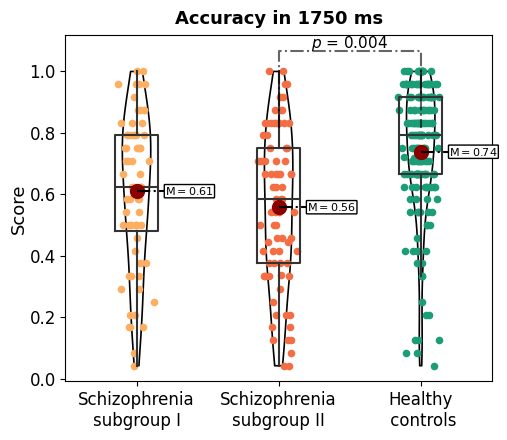



变量: Accuracy_in_750_ms
亚组I与健康对照组的Cohen's d: -0.128
亚组II与健康对照组的Cohen's d: -0.556
置换检验p值: 0.012
各组均值和标准差:
          Group   mean   std
Healthy control  0.040 0.207
      Subtypt I  0.010 0.268
     Subtypt II -0.096 0.277
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.647    0.128
Healthy control Subtypt II    0.000    0.556
      Subtypt I Subtypt II    0.024    0.386

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I   0.647    0.128
Healthy control Subtypt II   0.000    0.556
      Subtypt I Subtypt II   0.036    0.386


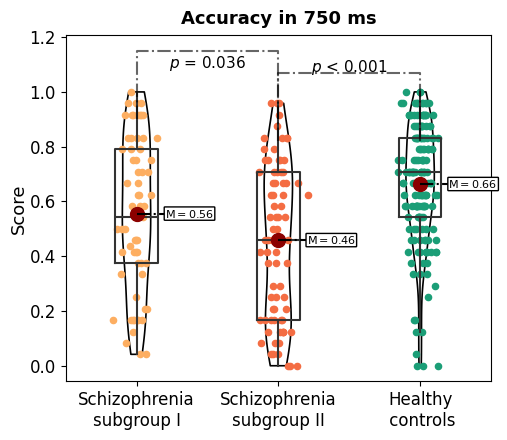



变量: Span_in_digit_span_backward_task
亚组I与健康对照组的Cohen's d: -0.301
亚组II与健康对照组的Cohen's d: -0.445
置换检验p值: 0.392
各组均值和标准差:
          Group   mean   std
Healthy control  0.291 1.846
      Subtypt I -0.255 1.781
     Subtypt II -0.411 1.247
事后检验结果:
原始p值:
              A          B  p-tukey  Cohen_d
Healthy control  Subtypt I    0.070    0.301
Healthy control Subtypt II    0.008    0.445
      Subtypt I Subtypt II    0.846    0.102

FDR BH校正后的p值:
              A          B  p-corr  Cohen_d
Healthy control  Subtypt I   0.105    0.301
Healthy control Subtypt II   0.024    0.445
      Subtypt I Subtypt II   0.846    0.102


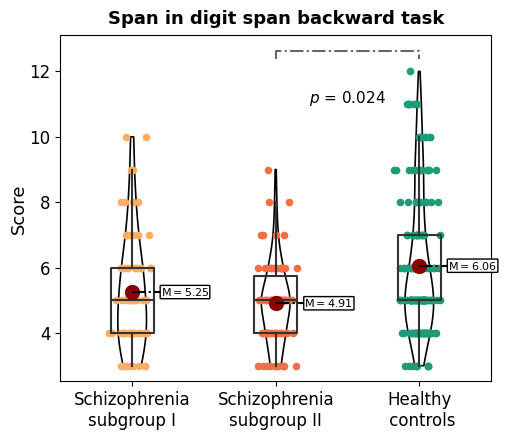



效应量和置换检验p值已保存到 Excel 文件: ./output_folder/output3/effect_sizes_and_permutation_p_values.xlsx

所有事后检验完成。


In [1]:
import pandas as pd
import pingouin as pg
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os
from statsmodels.formula.api import ols
from scipy.stats import f_oneway

# 忽略SettingWithCopyWarning警告
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# 绘图颜色和位置设置
BG_WHITE = '#ffffff'
BLACK = "#000000"
GREY_DARK = "#333333"
RED_DARK = "#8B0000"
COLOR_SCALE = ["#fdae61", "#f46d43", "#1b9e77"] 
POSITIONS = [0, 1, 2]

def analyze_data(data, dependent_vars, covariates_cont, socio_demo_vars_cat, output_folder):
    # 替换Group中的数值为描述性标签
    data.loc[:, 'Group'] = data['Group'].replace({0: 'Subtypt I', 1: 'Subtypt II', 2: 'Healthy control'})
    # 创建一个虚拟的被试变量
    data['Subject'] = range(1, len(data) + 1)

    # One-Hot编码社会人口学分类变量
    data = pd.get_dummies(data, columns=socio_demo_vars_cat, drop_first=False)

    # 将虚拟变量显式转换为数值型
    for var in [col for col in data.columns if any(v in col for v in socio_demo_vars_cat)]:
        data[var] = data[var].astype(float)

    # 更新协变量列表,包括连续型协变量和虚拟变量
    covariates = covariates_cont + [col for col in data.columns if any(var in col for var in socio_demo_vars_cat)]

    # 使用GLM模型,将执行功能变量回归掉社会人口学变量,得到残差
    residuals = pd.DataFrame()
    for var in dependent_vars:
        formula = f"{var} ~ {' + '.join(covariates)}"
        model = ols(formula, data).fit()
        residuals[var] = model.resid

    # 将Group变量添加到残差数据框中
    residuals['Group'] = data['Group']

    # 针对三组残差进行单因素方差分析
    anova_results = []
    for var in dependent_vars:
        group1 = residuals[residuals['Group'] == 'Subtypt I'][var]
        group2 = residuals[residuals['Group'] == 'Subtypt II'][var]
        group3 = residuals[residuals['Group'] == 'Healthy control'][var]

        f, p = f_oneway(group1, group2, group3)
        eta_squared = (f * 2) / (f * 2 + residuals.shape[0] - 3)  # 计算效应量
        anova_results.append({'Variable': var, 'F': f, 'p': p, 'Eta_squared': eta_squared})

    anova_results_df = pd.DataFrame(anova_results)

    # 对p值进行FDR BH矫正
    anova_results_df['p_corr'] = multipletests(anova_results_df['p'], method='fdr_bh')[1]
    
    # 四舍五入显示p值
    anova_results_df['p'] = anova_results_df['p'].round(3)
    anova_results_df['p_corr'] = anova_results_df['p_corr'].round(3)
    anova_results_df['Eta_squared'] = anova_results_df['Eta_squared'].round(3)
    anova_results_df['F'] = anova_results_df['F'].round(3)

    # 打印单因素方差分析的结果
    print("\n单因素方差分析结果:")
    print("原始p值及FDR BH矫正后的p值:")
    print(anova_results_df.to_string(index=False))

    # Initialize a list to store the effect sizes and permutation p-values
    effect_sizes = []
    permutation_p_values = []

    # 对p值显著的变量进行事后检验,并按三线表输出
    for _, row in anova_results_df[anova_results_df['p_corr'] < 0.3].iterrows():
        var = row['Variable']
        print(f"\n变量: {var}")

        # 计算亚组I与健康对照组、亚组II与健康对照组的Cohen's d值
        group1_data = residuals[residuals['Group'] == 'Subtypt I'][var]
        group2_data = residuals[residuals['Group'] == 'Subtypt II'][var]
        group3_data = residuals[residuals['Group'] == 'Healthy control'][var]

        cohen_d_1_3 = (group1_data.mean() - group3_data.mean()) / np.sqrt((group1_data.var() + group3_data.var()) / 2)
        cohen_d_2_3 = (group2_data.mean() - group3_data.mean()) / np.sqrt((group2_data.var() + group3_data.var()) / 2)

        # Save effect sizes in the list
        effect_sizes.append({
            'Variable': var,
            'Cohen_d_SubtyptI_vs_Healthy': cohen_d_1_3,
            'Cohen_d_SubtyptII_vs_Healthy': cohen_d_2_3
        })

        print(f"亚组I与健康对照组的Cohen's d: {cohen_d_1_3:.3f}")
        print(f"亚组II与健康对照组的Cohen's d: {cohen_d_2_3:.3f}")

        # 进行置换检验
        num_permutations = 10000
        diff_observed = np.abs(cohen_d_1_3 - cohen_d_2_3)
        combined_data = np.concatenate((group1_data, group2_data, group3_data))

        diff_permuted = []
        for _ in range(num_permutations):
            permuted_data = np.random.permutation(combined_data)
            perm_group1 = permuted_data[:len(group1_data)]
            perm_group2 = permuted_data[len(group1_data):len(group1_data) + len(group2_data)]
            perm_group3 = permuted_data[len(group1_data) + len(group2_data):]

            perm_cohen_d_1_3 = (perm_group1.mean() - perm_group3.mean()) / np.sqrt((perm_group1.var() + perm_group3.var()) / 2)
            perm_cohen_d_2_3 = (perm_group2.mean() - perm_group3.mean()) / np.sqrt((perm_group2.var() + perm_group3.var()) / 2)

            diff_permuted.append(np.abs(perm_cohen_d_1_3 - perm_cohen_d_2_3))

        p_value = (np.sum(diff_permuted >= diff_observed) + 1) / (num_permutations + 1)
        permutation_p_values.append({
            'Variable': var,
            'Permutation_p_value': p_value
        })

        print(f"置换检验p值: {p_value:.3f}")
        
        # 计算每组的均值和标准差
        group_stats = residuals.groupby('Group')[var].agg(['mean', 'std']).reset_index()
        group_stats['mean'] = group_stats['mean'].round(3)
        group_stats['std'] = group_stats['std'].round(3)

        print("各组均值和标准差:")
        print(group_stats.to_string(index=False))

        # 进行事后检验
        post_hoc = pg.pairwise_tukey(dv=var, between='Group', data=residuals)
        post_hoc['p-unc'] = post_hoc['p-tukey']  # 保存未矫正的p值
        post_hoc['p-corr'] = multipletests(post_hoc['p-tukey'], method='fdr_bh')[1]
        
        # 四舍五入显示p值
        post_hoc['p-tukey'] = post_hoc['p-tukey'].round(3)
        post_hoc['p-corr'] = post_hoc['p-corr'].round(3)

        # 计算事后比较的效应量
        for _, ph_row in post_hoc.iterrows():
            group1_data = residuals[residuals['Group'] == ph_row['A']][var]
            group2_data = residuals[residuals['Group'] == ph_row['B']][var]
            cohen_d = (group1_data.mean() - group2_data.mean()) / np.sqrt((group1_data.var() + group2_data.var()) / 2)
            post_hoc.loc[post_hoc.index == ph_row.name, 'Cohen_d'] = cohen_d

        post_hoc['Cohen_d'] = post_hoc['Cohen_d'].round(3)
        
        print("事后检验结果:")
        print("原始p值:")
        print(post_hoc[['A', 'B', 'p-tukey', 'Cohen_d']].to_string(index=False))
        print("\nFDR BH校正后的p值:")
        print(post_hoc[['A', 'B', 'p-corr', 'Cohen_d']].to_string(index=False))

        # 绘制箱线图和小提琴图
        fig, ax = plt.subplots(figsize=(5.2, 4.5))

        # Layout settings
        fig.patch.set_facecolor(BG_WHITE)
        ax.set_facecolor(BG_WHITE)

        # 获取三组原始数据
        group1_data = data[data['Group'] == 'Subtypt I'][var]
        group2_data = data[data['Group'] == 'Subtypt II'][var]
        group3_data = data[data['Group'] == 'Healthy control'][var]

        # Violin plot
        y_data = [group1_data, group2_data, group3_data]
        violins = ax.violinplot(
            y_data,
            positions=POSITIONS,
            widths=0.2,
            bw_method="silverman",
            showmeans=False,
            showmedians=False,
            showextrema=False
        )

        for pc in violins["bodies"]:
            pc.set_facecolor("none")
            pc.set_edgecolor(BLACK)
            pc.set_linewidth(1.2)
            pc.set_alpha(1)

        # Box plot properties
        medianprops = dict(
            linewidth=1.5,
            color=GREY_DARK,
            solid_capstyle="butt"
        )
        boxprops = dict(
            linewidth=1.5,
            color=GREY_DARK
        )

        ax.boxplot(
            y_data,
            positions=POSITIONS,
            showfliers=False,
            showcaps=False,
            medianprops=medianprops,
            whiskerprops=boxprops,
            boxprops=boxprops
        )

        # Jittered scatter plot
        x_jittered = [np.random.normal(pos, 0.06, size=len(data)) for pos, data in zip(POSITIONS, y_data)]
        for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
            ax.scatter(x, y, s=20, color=color, alpha=1)

        means = [y.mean() for y in y_data]
        for i, mean in enumerate(means):
            # Dot representing the mean
            ax.scatter(i, mean, s=100, color=RED_DARK, zorder=3)

            # Line connecting mean value and its label
            ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)

            ax.text(
                i + 0.2,
                mean,
                r"${\rm{M}} = $" + str(round(mean, 2)),
                fontsize=8,
                va="center",
                bbox=dict(
                    facecolor="white",
                    boxstyle="round",
                    pad=0.06
                ),
                zorder=8
            )

        # Significance lines and labels
        tick_len = 0.25

        p_corrected = post_hoc['p-corr'].values

        for i, (p, p_orig) in enumerate(zip(p_corrected, post_hoc['p-corr'].values)):
            if p_orig < 0.05:
                if i == 1:
                    ax.plot(
                        [1, 1, 2, 2],
                        [
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()) - tick_len,
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()),
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()),
                            data[var].max() + 0.07 * (data[var].max() - data[var].min()) - tick_len
                        ],
                        linestyle='-.', color='black', alpha=0.6
                    )

                    label3 = r"$p$ < 0.001" if p < 0.001 else r"$p$ = " + f"{p:.3f}"
                    pad = 0.2
                    ax.text(1.5, data[var].max() -0.145 * (data[var].max() - data[var].min()) + pad,
                            label3, fontsize=11, va="bottom", ha="center")
                elif i == 0:
                    ax.plot(
                        [0, 0, 2, 2],
                        [
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()) - tick_len,
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()),
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()),
                            data[var].max() + 0.3 * (data[var].max() - data[var].min()) - tick_len
                        ],
                        linestyle='-.', color='black', alpha=0.6
                    )

                    label2 = r"$p$ < 0.001" if p < 0.001 else r"$p$ = " + f"{p:.3f}"
                    pad = 0.2
                    ax.text(0.5, data[var].max() + 0.04 * (data[var].max() - data[var].min()) + pad,
                            label2, fontsize=11, va="bottom", ha="center")
                elif i == 2:
                    ax.plot(
                        [0, 0, 1, 1],
                        [
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()) - tick_len,
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()),
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()),
                            data[var].max() + 0.15 * (data[var].max() - data[var].min()) - tick_len
                        ],
                        linestyle='-.', color='black', alpha=0.6
                    )

                    label1 = r"$p$ < 0.001" if p < 0.001 else r"$p$ = " + f"{p:.3f}"
                    pad = 0.2
                    ax.text(0.5, data[var].max() - 0.13 * (data[var].max() - data[var].min()) + pad,
                            label1, fontsize=11, va="bottom", ha="center")

        # Add title and labels
        title = var.replace("_", " ")
        ax.set_title(f"{title}", fontsize=13, fontweight="bold", pad=8)
        ax.set_ylabel(f"Score", fontsize=13, labelpad=1)
        ax.set_xticks(POSITIONS)
        ax.set_xticklabels(['Schizophrenia\nsubgroup I', 'Schizophrenia\nsubgroup II', 'Healthy\n controls'])

        # Set axis label size
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        # Save figure
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f"{var}_plot.jpg"), dpi=1200)

        # Show figure
        plt.show()

        print()

    # Save the effect sizes and permutation p-values to an Excel file
    effect_sizes_df = pd.DataFrame(effect_sizes)
    permutation_p_values_df = pd.DataFrame(permutation_p_values)
    results_df = pd.merge(effect_sizes_df, permutation_p_values_df, on="Variable", how="outer")

    results_filename = os.path.join(output_folder, "effect_sizes_and_permutation_p_values.xlsx")
    results_df.to_excel(results_filename, index=False)

    print("\n效应量和置换检验p值已保存到 Excel 文件:", results_filename)

    if not anova_results_df[anova_results_df['p_corr'] < 0.3].empty:
        print("\n所有事后检验完成。")
    else:
        print("\n没有变量需要进行事后检验。")

# 分析第一部分数据
data1 = pd.read_excel('执行功能.xlsx', sheet_name='Sheet1')
data1_cleaned = data1[data1['Group'] != 3]

dependent_vars1 = ['Reaction_times_in_incongruent_stimuli', 'Stroop_interference_effect']
covariates_cont1 = ['Age', 'Education_years', 'RPM']
socio_demo_vars_cat1 = ['Gender', 'Smoking_status']

output_folder1 = "./output_folder/output1"
os.makedirs(output_folder1, exist_ok=True)
analyze_data(data1_cleaned, dependent_vars1, covariates_cont1, socio_demo_vars_cat1, output_folder1)

# 分析第二部分数据
data2 = pd.read_excel('执行功能.xlsx', sheet_name='Sheet1') 
data2_cleaned = data2[data2['Group'] != 3]

dependent_vars2 = ['Accuracy_in_No_Go_trials','Switching_cost']
covariates_cont2 = ['Age', 'Education_years'] 
socio_demo_vars_cat2 = ['Gender', 'Only_child']

output_folder2 = "./output_folder/output2"
os.makedirs(output_folder2, exist_ok=True)
analyze_data(data2_cleaned, dependent_vars2, covariates_cont2, socio_demo_vars_cat2, output_folder2)

# 分析第三部分数据
data3 = pd.read_excel('执行功能.xlsx', sheet_name='Sheet1')
data3_cleaned = data3[data3['Group'] != 3]

dependent_vars3 = ['Accuracy_in_1750_ms', 'Accuracy_in_750_ms', 'Span_in_digit_span_backward_task']
covariates_cont3 = ['Age', 'Education_years','BMI','RPM']
socio_demo_vars_cat3 = ['Gender','Marital_status','Smoking_status']

output_folder3 = "./output_folder/output3"
os.makedirs(output_folder3, exist_ok=True)
analyze_data(data3_cleaned, dependent_vars3, covariates_cont3, socio_demo_vars_cat3, output_folder3)

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

# 读取数据
data = pd.read_excel('执行功能.xlsx', sheet_name='Sheet1')
data_cleaned = data[data['Group'] != 3]  # 如果有 Group==3 的行，则过滤（此变量在后续未使用）

# 替换 Group 中的数值为描述性标签
data['Group'] = data['Group'].replace({
    0: 'Subtypt I',
    1: 'Subtypt II',
    2: 'Healthy control'
})

# 创建一个虚拟的被试变量
data['Subject'] = range(1, len(data) + 1)

# 定义自变量、因变量和协变量
independent_var = 'Group'
dependent_vars = [
    'Reaction_times_in_incongruent_stimuli',
    'Stroop_interference_effect',
    'Accuracy_in_No_Go_trials',
    'Switching_cost',
    'Accuracy_in_1750_ms',
    'Accuracy_in_750_ms',
    'Span_in_digit_span_backward_task'
]
covariates_cont = ['Age', 'Education_years']       # 连续协变量
socio_demo_vars_cat = ['Gender']                   # 分类协变量

# 对社会人口学分类变量进行 One-Hot 编码
data = pd.get_dummies(data, columns=socio_demo_vars_cat, drop_first=True)

# 将所有由分类变量产生的虚拟变量转换为 float
for col in data.columns:
    if any(cat in col for cat in socio_demo_vars_cat):
        data[col] = data[col].astype(float)

# 更新协变量列表，包含连续协变量和虚拟变量
covariates = covariates_cont + [
    col for col in data.columns
    if any(cat in col for cat in socio_demo_vars_cat)
]

# 计算并打印三组原始数据的均值和标准差
print("原始数据的均值和标准差：")
for var in dependent_vars:
    g1 = data[data[independent_var] == 'Subtypt I'][var]
    g2 = data[data[independent_var] == 'Subtypt II'][var]
    g3 = data[data[independent_var] == 'Healthy control'][var]
    print(f"{var} 均值±标准差 (Subtypt I): {g1.mean():.3f} ± {g1.std():.3f}")
    print(f"{var} 均值±标准差 (Subtypt II): {g2.mean():.3f} ± {g2.std():.3f}")
    print(f"{var} 均值±标准差 (Healthy control): {g3.mean():.3f} ± {g3.std():.3f}")
    print()

# 对 Reaction_times_in_incongruent_stimuli 做组间两独立样本 t 检验
rt1 = data[data[independent_var] == 'Subtypt I']['Reaction_times_in_incongruent_stimuli']
rt2 = data[data[independent_var] == 'Subtypt II']['Reaction_times_in_incongruent_stimuli']
rt3 = data[data[independent_var] == 'Healthy control']['Reaction_times_in_incongruent_stimuli']

t12, p12 = ttest_ind(rt1, rt2, equal_var=False)
t13, p13 = ttest_ind(rt1, rt3, equal_var=False)
t23, p23 = ttest_ind(rt2, rt3, equal_var=False)

print("Reaction_times_in_incongruent_stimuli 组间 t 检验：")
print(f"Subtypt I vs Subtypt II: t = {t12:.3f}, p = {p12:.3f}")
print(f"Subtypt I vs Healthy control: t = {t13:.3f}, p = {p13:.3f}")
print(f"Subtypt II vs Healthy control: t = {t23:.3f}, p = {p23:.3f}")
print()

# 对所有因变量进行标准化
scaler = StandardScaler()
data[dependent_vars] = scaler.fit_transform(data[dependent_vars])

原始数据的均值和标准差：
Reaction_times_in_incongruent_stimuli 均值±标准差 (Subtypt I): 733.517 ± 152.853
Reaction_times_in_incongruent_stimuli 均值±标准差 (Subtypt II): 768.219 ± 151.810
Reaction_times_in_incongruent_stimuli 均值±标准差 (Healthy control): 663.606 ± 149.016

Stroop_interference_effect 均值±标准差 (Subtypt I): -22.925 ± 57.335
Stroop_interference_effect 均值±标准差 (Subtypt II): -13.465 ± 80.008
Stroop_interference_effect 均值±标准差 (Healthy control): -7.036 ± 44.233

Accuracy_in_No_Go_trials 均值±标准差 (Subtypt I): 0.839 ± 0.130
Accuracy_in_No_Go_trials 均值±标准差 (Subtypt II): 0.839 ± 0.120
Accuracy_in_No_Go_trials 均值±标准差 (Healthy control): 0.879 ± 0.108

Switching_cost 均值±标准差 (Subtypt I): 303.861 ± 290.091
Switching_cost 均值±标准差 (Subtypt II): 310.507 ± 312.722
Switching_cost 均值±标准差 (Healthy control): 198.952 ± 238.374

Accuracy_in_1750_ms 均值±标准差 (Subtypt I): 0.610 ± 0.248
Accuracy_in_1750_ms 均值±标准差 (Subtypt II): 0.558 ± 0.255
Accuracy_in_1750_ms 均值±标准差 (Healthy control): 0.739 ± 0.215

Accuracy_in_750_ms 均值±标准差 (Sub

In [2]:
# 计算 Stroop_interference_effect 组间两独立样本 t 检验
sie1 = data[data[independent_var] == 'Subtypt I']['Stroop_interference_effect']
sie2 = data[data[independent_var] == 'Subtypt II']['Stroop_interference_effect']
sie3 = data[data[independent_var] == 'Healthy control']['Stroop_interference_effect']

t12_sie, p12_sie = ttest_ind(sie1, sie2, equal_var=False)
t13_sie, p13_sie = ttest_ind(sie1, sie3, equal_var=False)
t23_sie, p23_sie = ttest_ind(sie2, sie3, equal_var=False)

print("Stroop_interference_effect 组间 t 检验：")
print(f"Subtypt I vs Subtypt II: t = {t12_sie:.3f}, p = {p12_sie:.3f}")
print(f"Subtypt I vs Healthy control: t = {t13_sie:.3f}, p = {p13_sie:.3f}")
print(f"Subtypt II vs Healthy control: t = {t23_sie:.3f}, p = {p23_sie:.3f}")

Stroop_interference_effect 组间 t 检验：
Subtypt I vs Subtypt II: t = -0.826, p = 0.410
Subtypt I vs Healthy control: t = -2.040, p = 0.044
Subtypt II vs Healthy control: t = -0.664, p = 0.508


In [6]:
print('分析全部完成！😂')

分析全部完成！😂
